# Kr NEW Fits

J. A Hernando, C. Herves

April 2022

In [6]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [7]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [8]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [9]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu May 12 14:12:25 2022


In [10]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [12]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEXT100/Kr/'
runs = 'MC00'

In [13]:
from os import listdir

run = 'MC00'
filenames = listdir(path+str(run))
filenames.sort()
print(len(filenames), filenames[0], filenames[-1])
filenames = [path + str(run) + '/' + ifile for ifile in filenames]

10000 dorothea_10000_kr83m.h5 dorothea_9_kr83m.h5


In [14]:
kdst = load_dsts(filenames, "DST", "Events")

In [15]:
kdst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [16]:
names = ['event', 'time', 'S2e', 'X', 'Y', 'Z', 'DT']
sel   = (kdst.nS1 == 1) & (kdst.nS2 == 1)
mkdst = kdst[sel][names]
mkdst['R'] = np.sqrt(mkdst.X**2 + mkdst.Y**2)
mkdst.replace(np.nan, 0.)
mkdst = mkdst.rename(columns = {'S2e' : 'energy', 'X' : 'x', 'Y' : 'y', 'Z' : 'z', 'DT' : 'dtime', 'R' : 'r'})

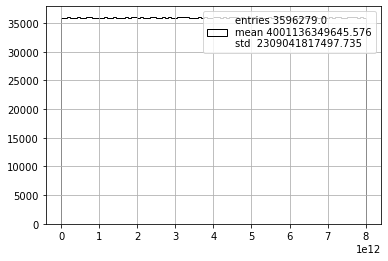

In [17]:
pltext.hist(mkdst.time, 100);

In [18]:
print('size ', len(mkdst))

size  3596279


In [80]:
sels = {}
sels['r']        = ut.in_range(mkdst.r  , (0., 450))
sels['dtime']    = ut.in_range(mkdst.dtime , (0., 1450.))
sels['energy']   = ut.in_range(mkdst.energy, (10e3, 20e4))
sels['fidutial'] = (sels['r']) & (sels['dtime']) & (sels['energy'])

In [81]:
mkdst.columns

Index(['event', 'time', 'energy', 'x', 'y', 'z', 'dtime', 'r'], dtype='object')

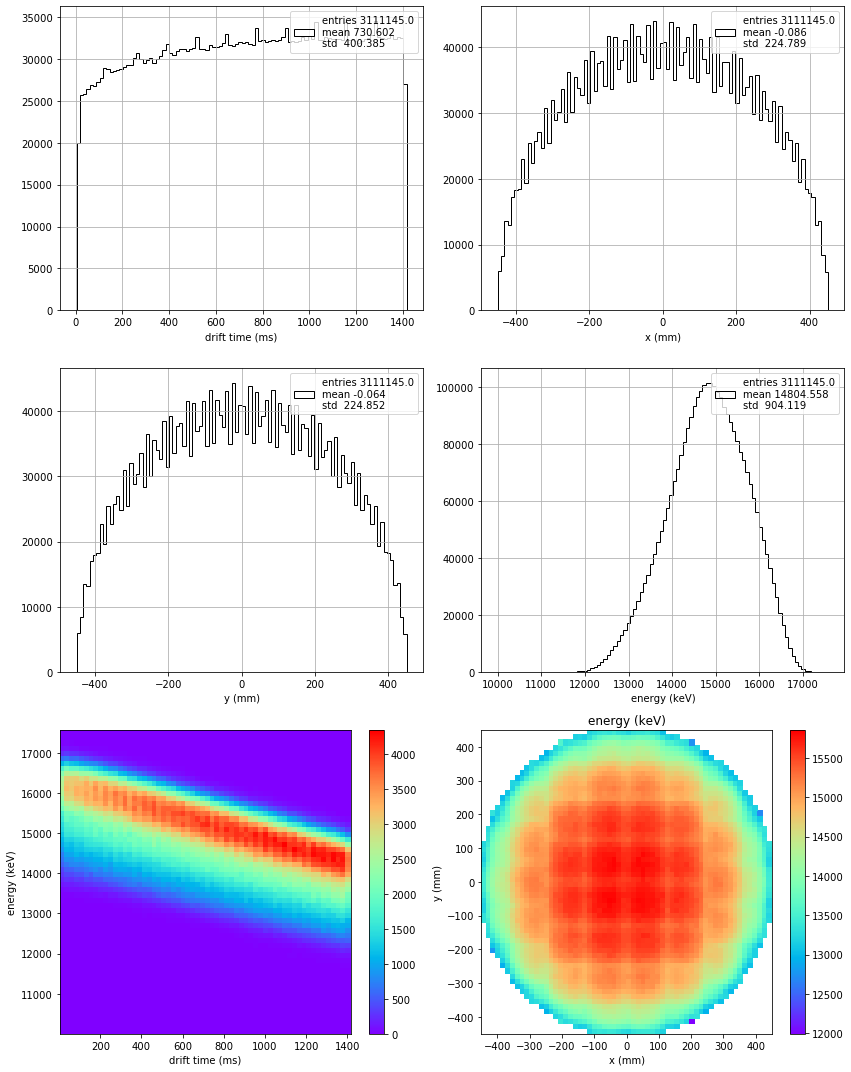

In [82]:
sel = sels['fidutial']
krana.plot_data(mkdst[sel], 60)

## Kr Map

In [83]:
coors  = mkdst[sel].x, mkdst[sel].y
energy = mkdst[sel].energy
dtime  = mkdst[sel].dtime
counts_min = 40
bins   = (40, 40) 
krmap  = krana.krmap(coors, dtime, energy, bins = bins, 
                     counts_min = counts_min, dt0 = 0.)

In [84]:
def clean_krmap(coors, dtime, energy):
    sel     = np.ones(len(energy), bool)
    clean   = np.copy(sel)
    done    = False
    while (not done):
        icoors  = [coor[clean] for coor in coors]
        idtime  = dtime[clean]
        iene    = energy[clean]
        krmap   = krana.krmap(icoors, idtime, iene, bins = bins, counts_min = counts_min, dt0 = 0.)
        done, usel = krana.accept_residuals(krmap.residuals, range = (-5.,5.), 
                                            fun = 'gaus', nsigma = 4., min_sigma = 0.98, plot = True)
        clean[clean == True] = usel
    return krmap, clean

## Clean KrMap

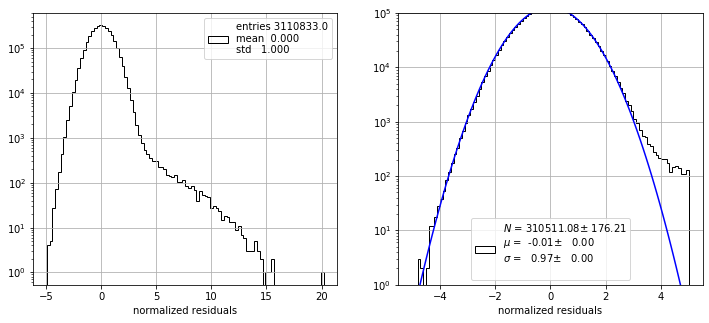

sigma 0.97 done  False  eff 99.85


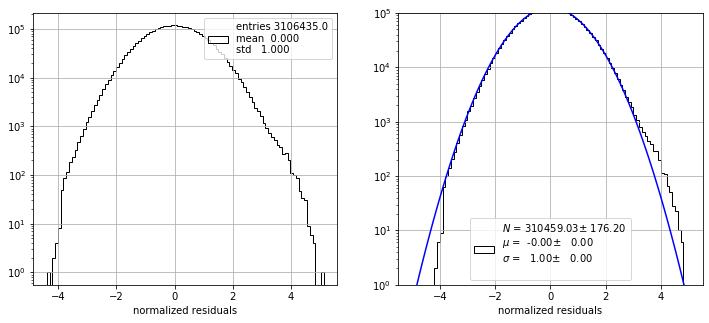

sigma 1.00 done  True  eff 100.00


In [85]:
krmap, usel = clean_krmap(coors, dtime, energy)

In [89]:
clean = np.ones(len(mkdst), bool)
fid   = sels['fidutial']
clean[fid == True] = usel

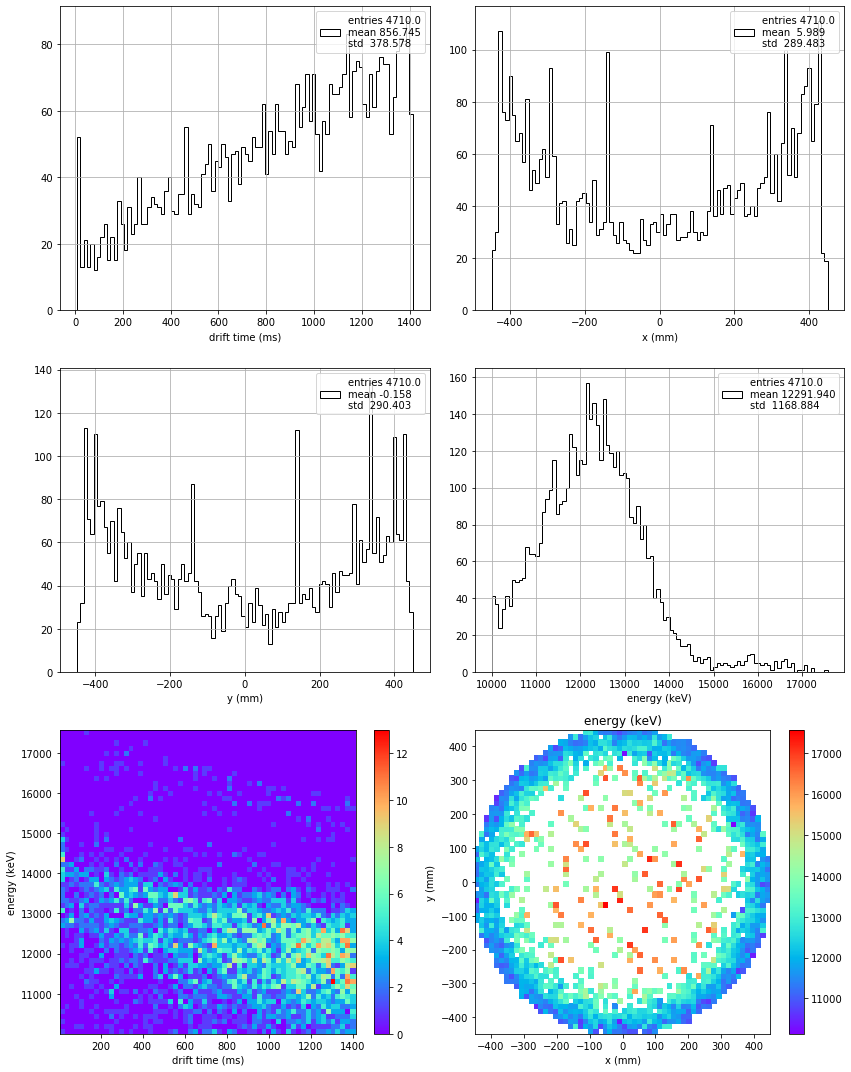

In [90]:
sels['clean'] = clean
krana.plot_data(mkdst[~clean], 60)

## KrMap with fidutual and clean events

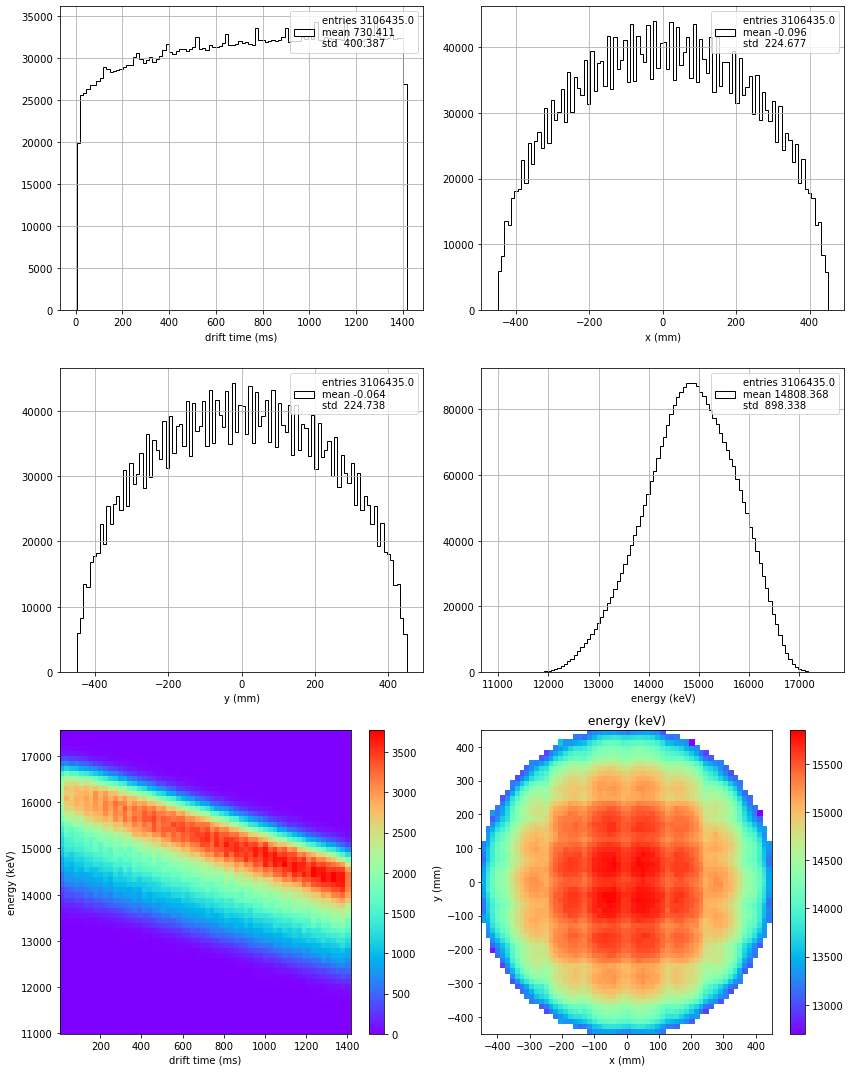

In [94]:
sel = sels['clean'] & sels['fidutial']
krana.plot_data(mkdst[sel], 60)

In [128]:
sel    = sels['clean'] & sels['fidutial']
coors  = mkdst[sel].x, mkdst[sel].y
energy = mkdst[sel].energy
dtime  = mkdst[sel].dtime
counts_min = 40
bins   = (120, 120) 
krmap  = krana.krmap(coors, dtime, energy, bins = bins, 
                     counts_min = counts_min, dt0 = None)

In [112]:
120*120

14400

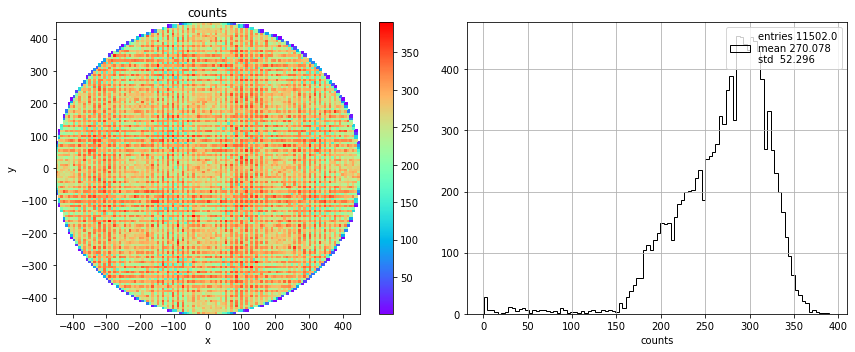

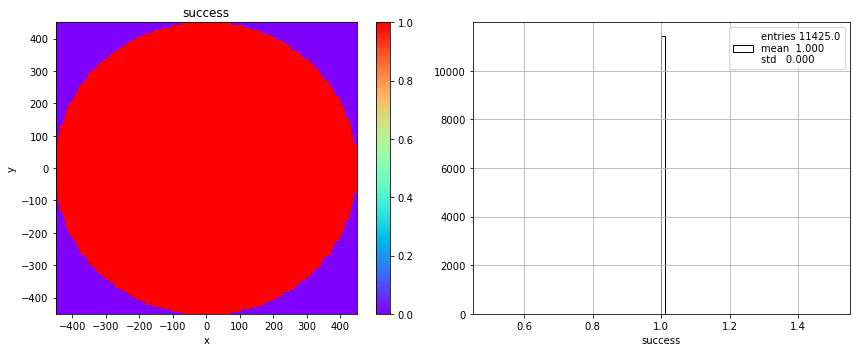

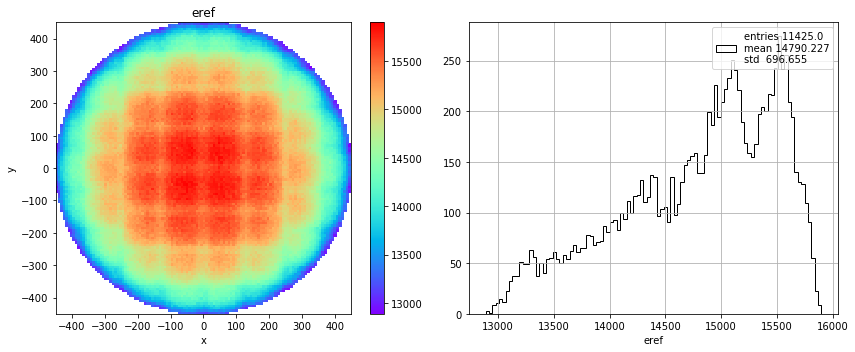

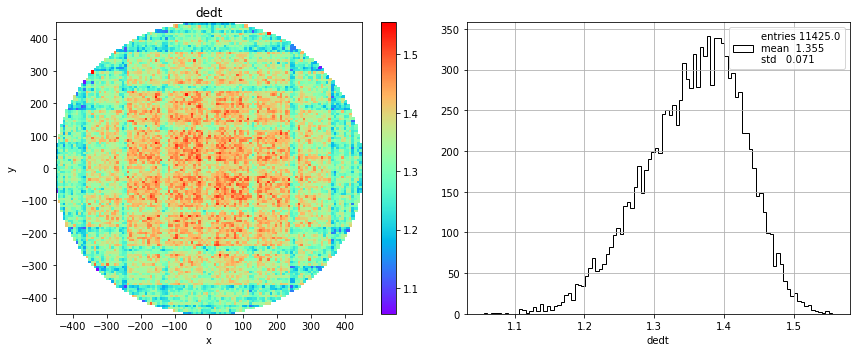

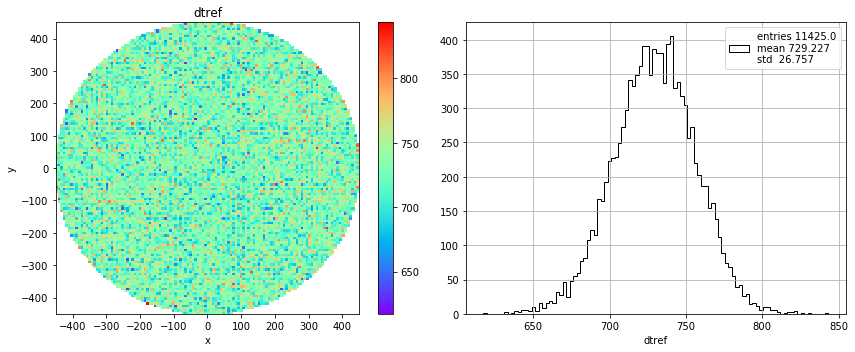

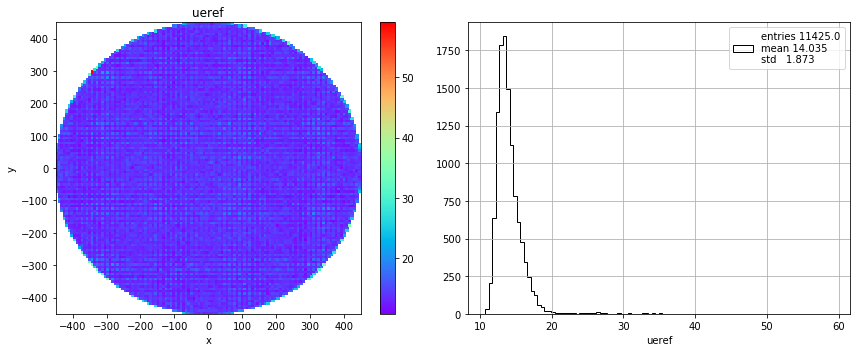

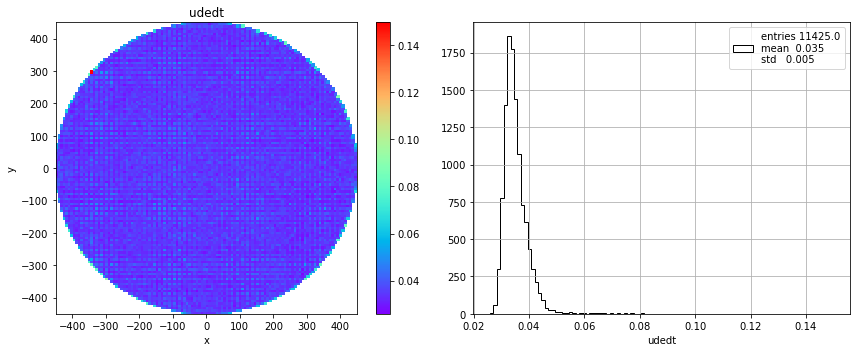

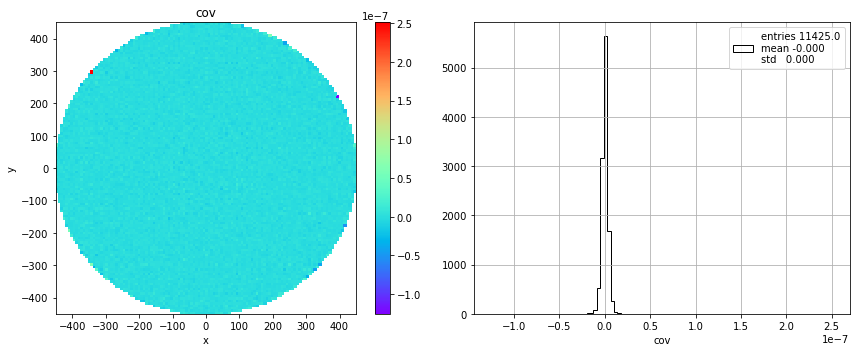

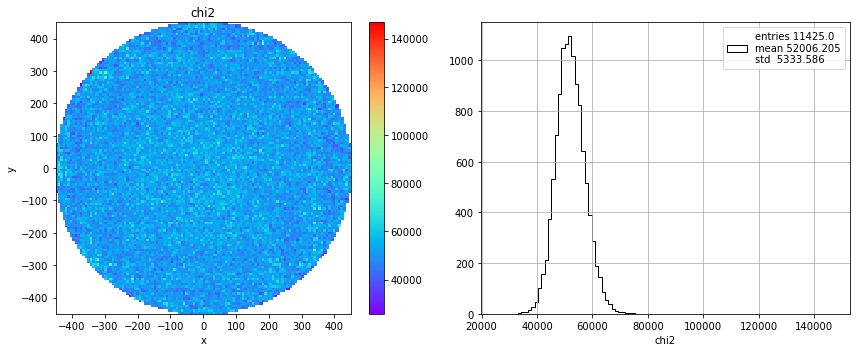

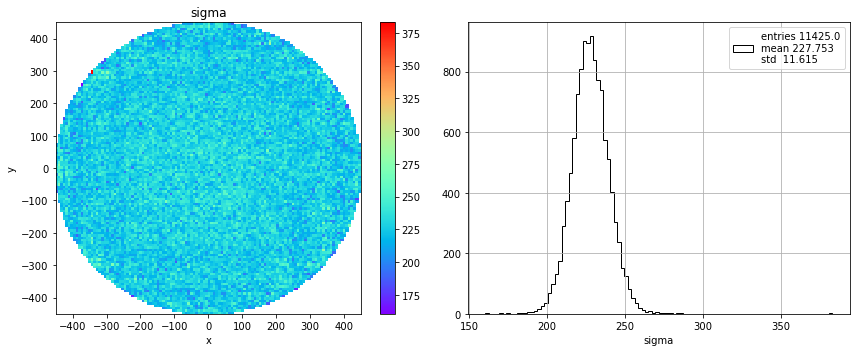

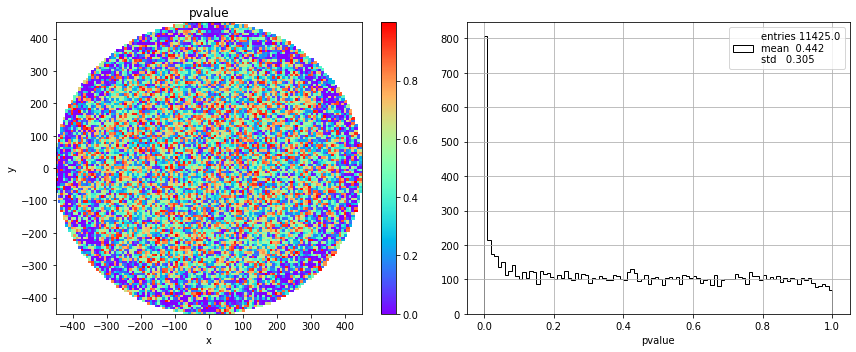

In [129]:
krana.plot_xyvar(krmap.counts , krmap.bin_edges, 'counts' , mask = krmap.counts > 0)
krana.plot_xyvar(krmap.success, krmap.bin_edges, 'success', mask = krmap.success)
krana.plot_xyvar(krmap.eref   , krmap.bin_edges, 'eref'   , mask = krmap.success)
krana.plot_xyvar(krmap.dedt   , krmap.bin_edges, 'dedt'   , mask = krmap.success)
krana.plot_xyvar(krmap.dtref  , krmap.bin_edges, 'dtref'  , mask = krmap.success)
krana.plot_xyvar(krmap.ueref  , krmap.bin_edges, 'ueref'  , mask = krmap.success)
krana.plot_xyvar(krmap.udedt  , krmap.bin_edges, 'udedt'  , mask = krmap.success)
krana.plot_xyvar(krmap.cov    , krmap.bin_edges, 'cov'    , mask = krmap.success)
krana.plot_xyvar(krmap.chi2   , krmap.bin_edges, 'chi2'   , mask = krmap.success)
krana.plot_xyvar(krmap.sigma  , krmap.bin_edges, 'sigma'  , mask = krmap.success)
krana.plot_xyvar(krmap.pvalue , krmap.bin_edges, 'pvalue' , mask = krmap.success)

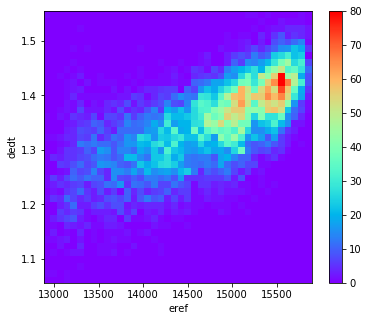

In [130]:
xsel = krmap.success
pltext.canvas(1, 1)
plt.hist2d(krmap.eref[xsel].ravel(), krmap.dedt[xsel].ravel(), (40, 40));
plt.colorbar(); plt.xlabel('eref'); plt.ylabel('dedt');

## Correction

In [115]:
corr_energy, _ = krana.krmap_scale(coors, dtime, energy, krmap, scale = 41.5)

 Resolution   3.61 % FWHM


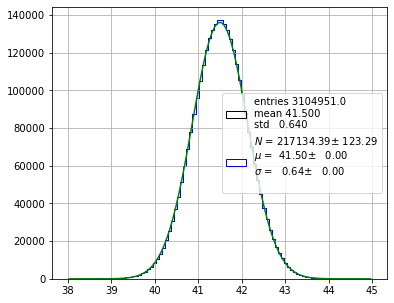

In [116]:
xsel = ~np.isnan(corr_energy)
nbins, erange = 100, (38., 45)
pltext.canvas(1, 1);
pltext.hist(corr_energy[xsel], nbins, erange);
cc = pltext.hfit(corr_energy[xsel], nbins, range = erange, fun = 'gaus');
pars = cc[3]
resolution = 235.5 * pars[2]/pars[1]
print(' Resolution {:6.2f} % FWHM'.format(resolution))

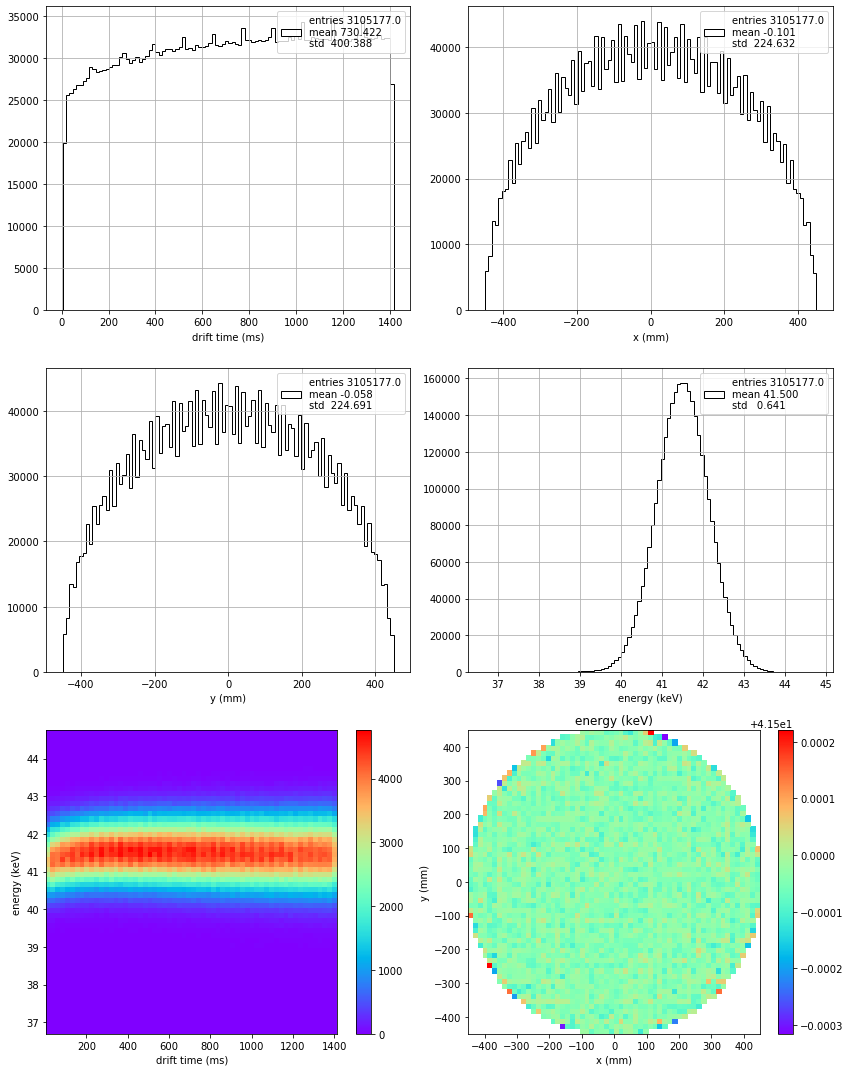

In [117]:
xsel = ~np.isnan(corr_energy)
df = {'x': coors[0][xsel], 'y' : coors[1][xsel], 'dtime': dtime[xsel], 'energy' : corr_energy[xsel]}
df = pd.DataFrame(df)
krana.plot_data(df, bins = 60)

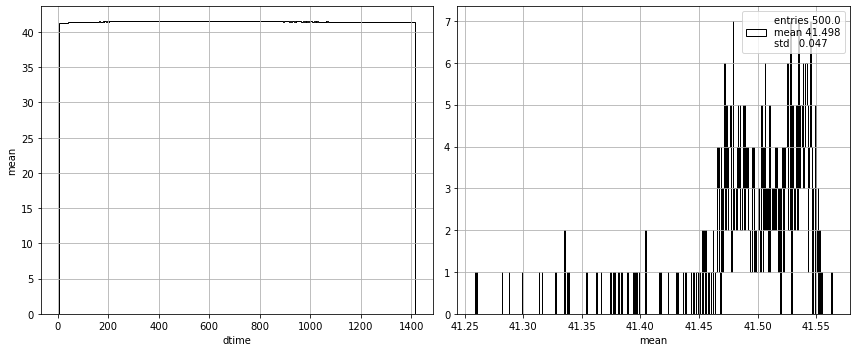

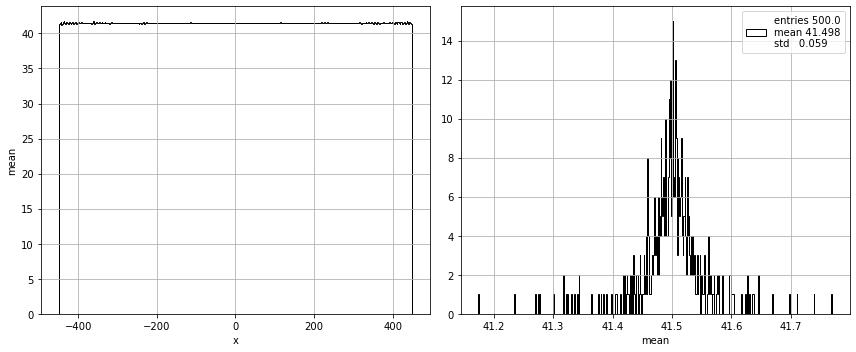

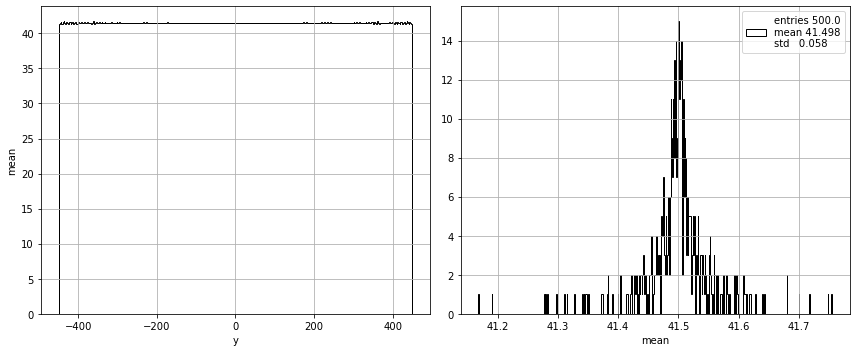

In [118]:
krana.plot_xydt_energy_profiles(df, nbins = 500)

## Refine the correction

In [121]:
xsel   = df.energy > 0.
coors  = df.x[xsel], df.y[xsel]
enes   = df.energy[xsel]
xyprof = prof.profile(coors, enes, 160)

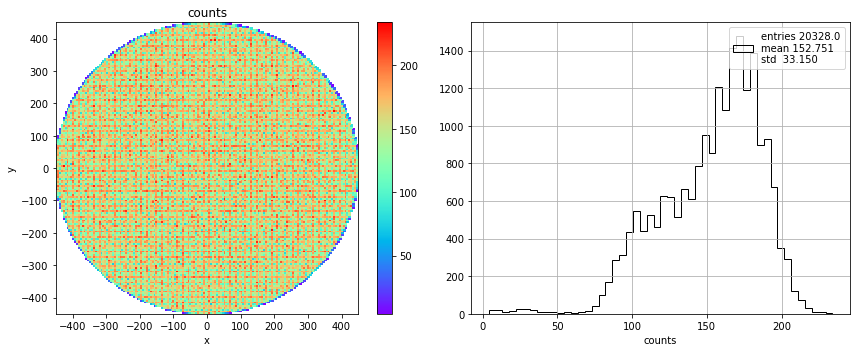

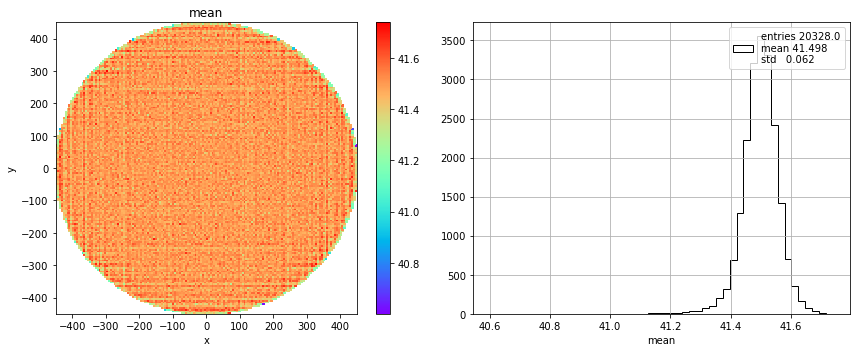

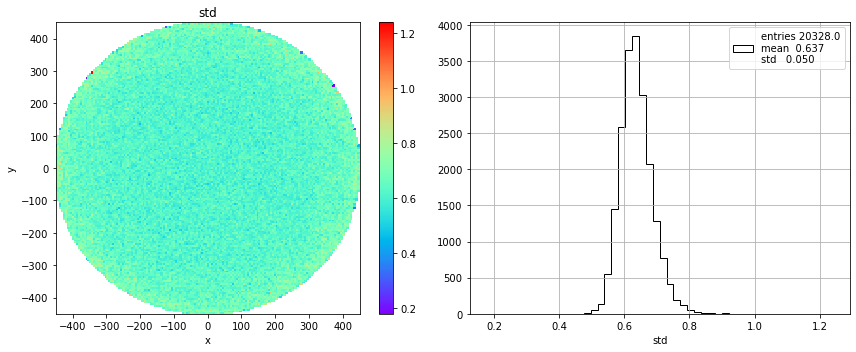

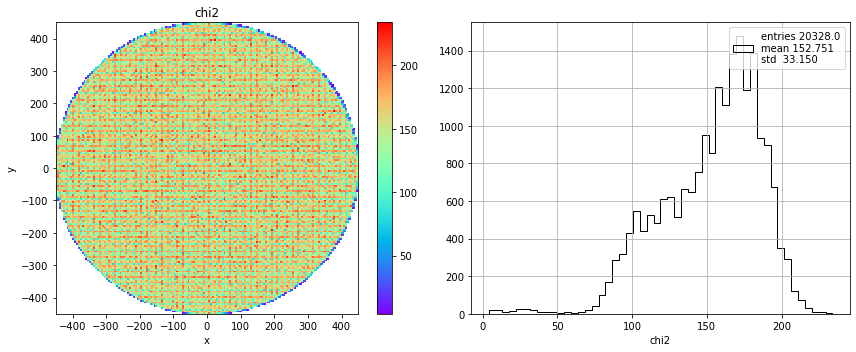

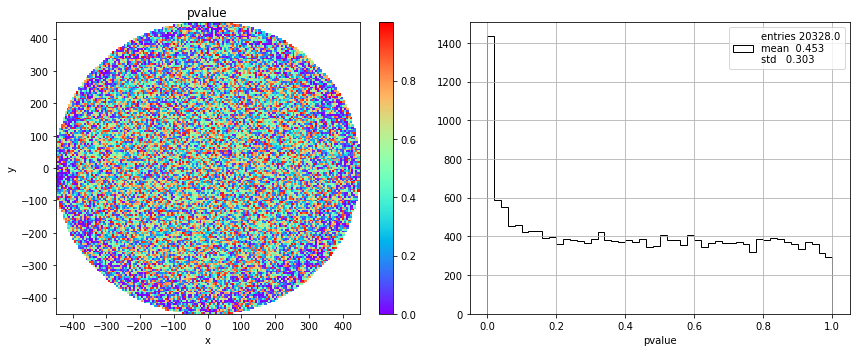

In [122]:
prof.plot_profile(xyprof);

In [123]:
correne = prof.profile_scale(coors, enes, xyprof, 41.5)

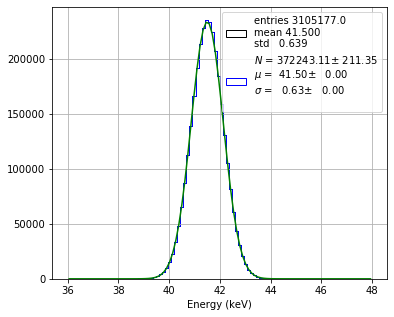

In [124]:
pltext.canvas(1, 1);
pltext.hist(correne, 100, (36, 48));
pltext.hfit(correne, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)');

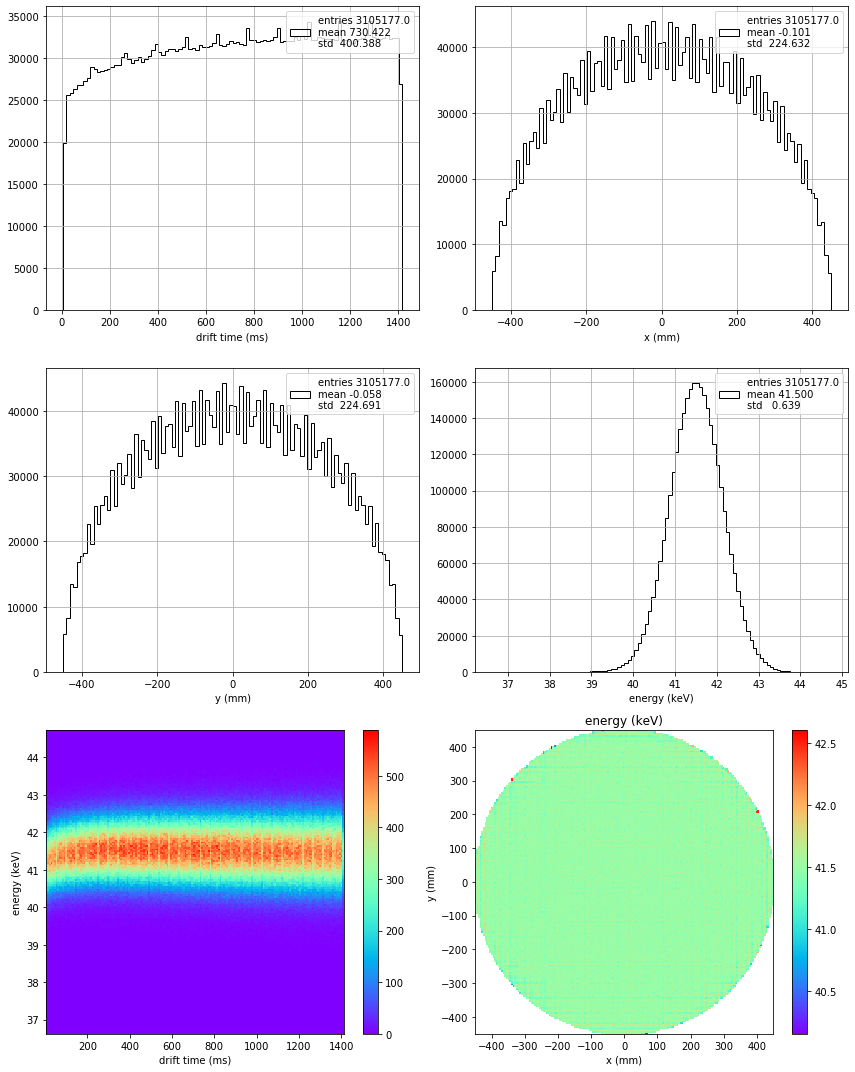

In [125]:
xdf = {'x': df.x[xsel], 'y': df.y[xsel], 'dtime': df.dtime[xsel], 'energy': correne}
xdf = pd.DataFrame(xdf)
krana.plot_data(xdf, bins = 180)

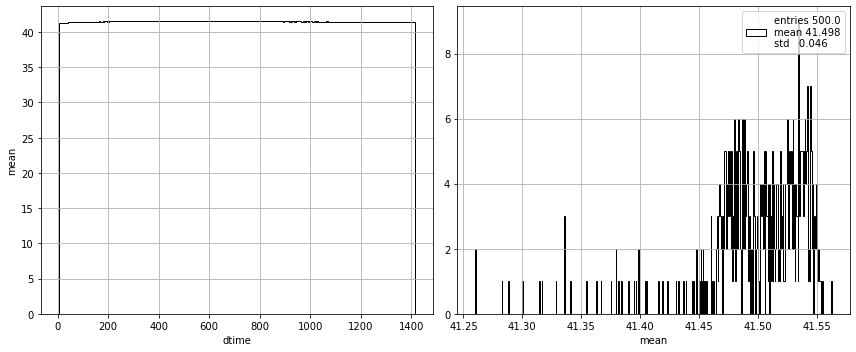

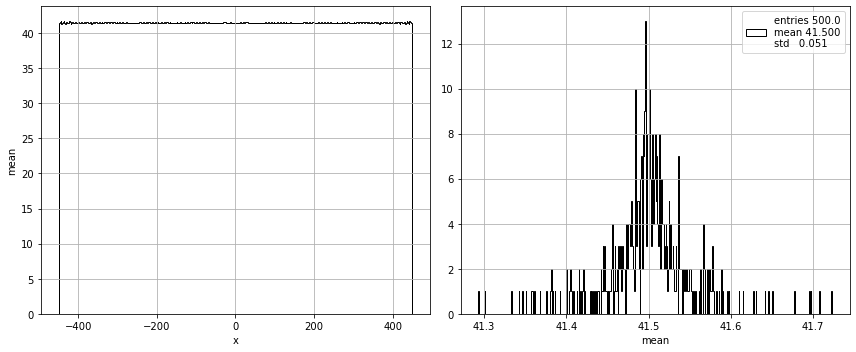

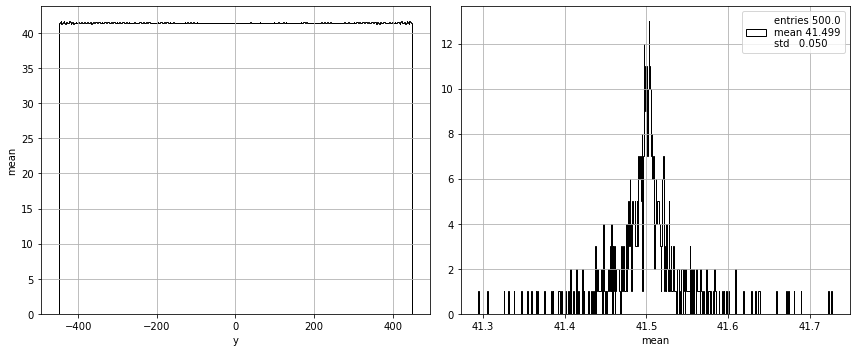

In [126]:
krana.plot_xydt_energy_profiles(xdf[xdf.energy > 0.], nbins = 500)

## Store

In [127]:
krana.krmap_save(krmap , 'krmap' , 'krmap_'+str(run)+'.h5');
krana.krmap_save(xyprof, 'xyprof', 'krmap_'+str(run)+'.h5');